In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_world = pd.read_csv("data/owid-covid-data.csv")

In [17]:
for col in df_world.columns:
    print(col)

iso_code
continent
location
date
total_cases
new_cases
new_cases_smoothed
total_deaths
new_deaths
new_deaths_smoothed
total_cases_per_million
new_cases_per_million
new_cases_smoothed_per_million
total_deaths_per_million
new_deaths_per_million
new_deaths_smoothed_per_million
new_tests
total_tests
total_tests_per_thousand
new_tests_per_thousand
new_tests_smoothed
new_tests_smoothed_per_thousand
tests_per_case
positive_rate
tests_units
stringency_index
population
population_density
median_age
aged_65_older
aged_70_older
gdp_per_capita
extreme_poverty
cardiovasc_death_rate
diabetes_prevalence
female_smokers
male_smokers
handwashing_facilities
hospital_beds_per_thousand
life_expectancy
human_development_index


In [6]:
df_world.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,0.0,0.0,NaN,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,0.0,0.0,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
3,ABW,North America,Aruba,2020-03-21,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
4,ABW,North America,Aruba,2020-03-22,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN


In [ ]:
df_world.col

In [18]:
df_world.location.unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Bonaire Sint Eustatius and Saba',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of Congo', 'Congo', 'Colombia', 'Comoros',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica',
       'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt',
       'Eritrea', 'Western Sahara', 'Spain', 'Estonia', 'Ethiopia',
       'Finland', 'Fiji', 'Falkland Islands', 'France',

In [6]:
df_meas = pd.read_csv("data/data_response_graphs_0.csv")

In [8]:
df_meas["Country"].unique()

array(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia',
       'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
       'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia',
       'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
       'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia',
       'Spain', 'Sweden', 'United Kingdom'], dtype=object)

In [7]:
countries = ["Germany", "Netherlands", "United Kingdom", "Italy"]
countrydata = {}
for country in countries:
    countrydata[country] = {}
    df_country = df_world.loc[df_world["location"] == country, :]
    df_country = df_country[50:-1]
    df_measures = df_meas.loc[df_meas.Country == country, :]
    countrydata[country]["data"] = df_country
    countrydata[country]["measures"] = df_measures
    
    

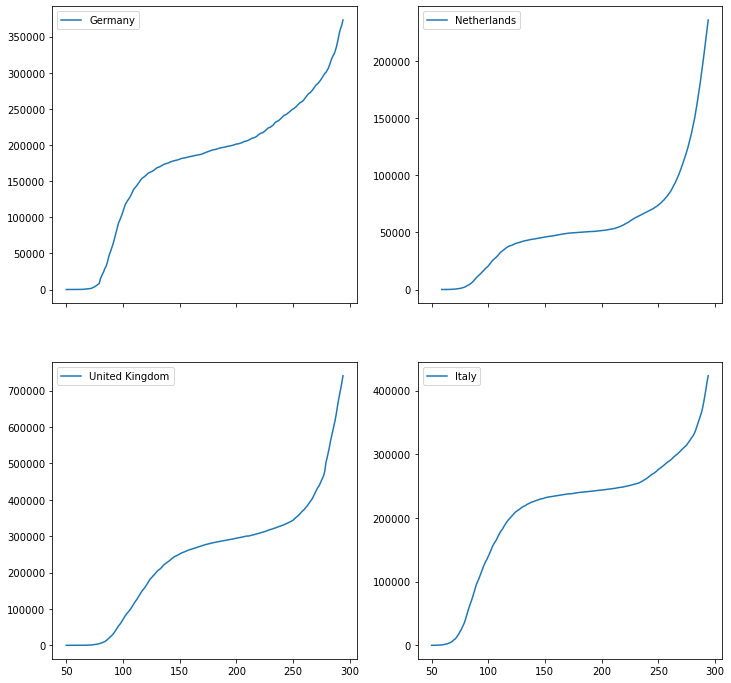

In [54]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharex=True)
ax = ax.flatten()

for (i, c) in enumerate(countries):
    dateidxs = np.arange(50, 50+len(countrydata[c]["data"]["date"]))
    ax[i].plot(dateidxs, countrydata[c]["data"]["total_cases"], label=c)
    ax[i].legend()

# The model: SEIRS

In [8]:
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

In [9]:
# SEIRS model with demography and a varying population size (i.e. different birth and death rates)
#initial conditions
def SEIRS(t, y, beta, sigma, gamma, nu, xi):
    S, E, I, R = y
    dSdt = -beta*I*S + xi*R
    dEdt = beta*S*I - sigma*E
    dIdt = sigma*E - gamma*I
    dRdt = gamma*I - xi*R
    return [dSdt, dEdt, dIdt, dRdt]


def solve_SEIRS(y0, tspan, args):
    sol = solve_ivp(SEIRS, tspan, y0, args=args, dense_output=True)
    return sol

In [51]:
sigma = 1/5 # latency period
xi = 0.01   # immunity loss
nu = 0.01   # death from infection

beta = 100.0
gamma = 90

args = (beta, sigma, gamma, nu, xi)

N_init = 1e6
S0 = (N_init-1)/N_init
E0 = 1/N_init
I0 = 0
R0 = 0

tspan = (0, 150)
y0 = [S0, E0, I0, R0]

sol = solve_SEIRS(y0, tspan, args)

In [52]:
t = np.linspace(0, 150, 1000)

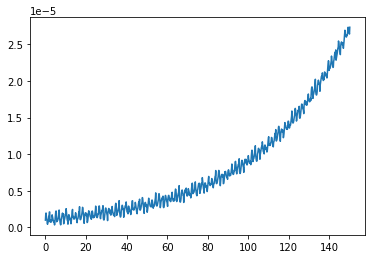

In [53]:
plt.plot(t, sol.sol(t)[1,:])

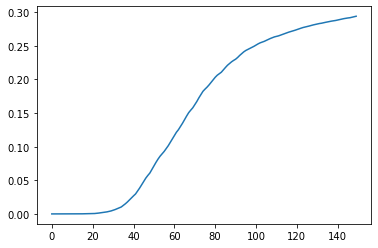

In [55]:
data = countrydata["United Kingdom"]["data"]["total_cases"][0:150]/N_init
plt.plot(np.arange(0, len(data)), data)

In [59]:
def model(t, beta, gamma):
    args = (beta, sigma, gamma, nu, xi)
    sol = solve_SEIRS(y0, tspan, args)
    return sol.sol(t)[2,:]

In [61]:
t = np.linspace(0, 150, len(data))
fit = curve_fit(model, t, data, p0=[3.0, 1.0])[0]

KeyboardInterrupt: 

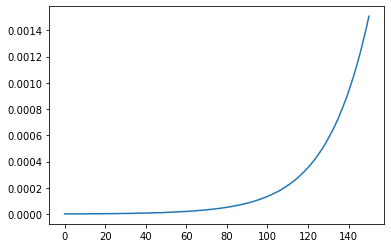

In [41]:
plt.plot(t, model(t, *fit))